# Alcoy Tourist

El objetivo de este proyecto es:

- Para poder lograr definir al municipio de Alcoi como Municipio Turístico es necesario averiguar cuántos turistas se encuentran en Alcoy en base a sus redes favoritas en sus teléfonos para poder ver si la afluencia de turistas en relación con los residentes de Alcoi es la que se establece en el Decreto de Municipio Turístico 2020.

Este objetivo no es sencillo porque no todos los visitantes tienen activado el Wifi de su teléfono....

Para lograr este objetivo analizaremos.....

In [538]:
# !pip install mplfinance
# !pip install chart_studio
# !pip install cufflinks

# Imports

In [539]:
import sweetviz as sv
import pandas as pd
from datetime import datetime
from collections import Counter
import sklearn.metrics as metrics
import plotly.express as px
import statsmodels.api as sm
%matplotlib inline
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from matplotlib import dates
import matplotlib.pyplot as plt
import mplfinance as mpf
import statsmodels.api as sm
import cufflinks as cf
init_notebook_mode(connected=True)
cf.go_offline()

# ETS significa Error Trend Seasonality y la descomposición ETS
# la usaremos para separar estos diferentes componentes de una
# serie temporal
from statsmodels.tsa.seasonal import seasonal_decompose

# Obtenemos los conjuntos de datos incorporados de Seaborn
#sns.get_dataset_names()

pd.options.plotting.backend = "plotly"

# Data

## Paths definition

In [540]:
DATA_PATH = 'data'
REPORTS_PATH = 'reports/'

## Data loading

En este proyecto dispondremos de tres dataset:

- `datosEncuesta2206`: contiene la información relativa a las encuestas realizadas a las personas que han visitado la oficina de turismo de Alcoy.
- `datosSensorTurismo2206`: dispone de información correspondientes a los 5 SSIDs favoritos de los moviles de las personas.
- `ssidsAlcoi`: este dataset contiene el SSiDs de los dispositivos como routers, de Alcoi, estos fueron recolectados y resistrados, a partir de estos datos se realizan los  filtros de los datos del sensor de turismo.

Nota: _En el conjunto de datos datos SSIDS Alcoi tenemos todas las direcciones de los puntos de conexión de la ciudad de Alocai._


In [541]:
quiz_df = pd.read_csv(f"{DATA_PATH}/datosEncuesta2206.csv")
sensor_df = pd.read_csv(f"{DATA_PATH}/datosSensorTurismo2206.csv")
ssids_df  = pd.read_csv(f"{DATA_PATH}/ssidsAlcoi.csv")

En el dataset datosSensorTurismo2206 tenemos 


De cada dispositivo, si la red a la que más se conecta no es de Alcoi es un turista.


De este criterio saldrá un listado de MAC (dispositivos) que visitantes.

## Data Analyisis

In [542]:
# quiz_report = sv.analyze(quiz_df)
# quiz_report.show_html(f"{REPORTS_PATH}/Quiz.html")

# sensor_report = sv.analyze(sensor_df)
# sensor_report.show_html(f"{REPORTS_PATH}/Sensors.html")

# ssids_report = sv.analyze(ssids_df)
# ssids_report.show_html(f"{REPORTS_PATH}/SSIDs.html")

In [543]:
sensor_df.sort_values('date', ascending = False)


,date,mac,ssid
41670,1651557308022,adb3077264a1cdaebd3f000e5106b938b686d5ba,7a592c4a3d20f50b2ba09a85b67c6d2fc925664b
41669,1651557247963,9d164cc8432ebbec973b72d0863104278159d59e,7a592c4a3d20f50b2ba09a85b67c6d2fc925664b
41668,1651517743891,68cdd2558ab66ae552181a6a1020d761b6070884,877a09473e70b0032058eedab1ac679086a2ad84
41667,1651517623913,16e6a88f3a1690cc46ea76f103b9ca50f2348623,877a09473e70b0032058eedab1ac679086a2ad84
41666,1651517503850,0d47b0ba9ff0d21c53891dd51d915db490c5d6cd,877a09473e70b0032058eedab1ac679086a2ad84
...,...,...,...
4,1624342199096,d29675014f618f3ef3f6b75f146b4be71c513c16,cca78a1e963f3ba3443bf3e54a9aa939f73d223d
3,1624342180676,5cbcffeab5fa9206a8c2712ef085daab688dd086,cca78a1e963f3ba3443bf3e54a9aa939f73d223d
2,1624342133875,d29675014f618f3ef3f6b75f146b4be71c513c16,cca78a1e963f3ba3443bf3e54a9aa939f73d223d
1,1624342089379,5cbcffeab5fa9206a8c2712ef085daab688dd086,cca78a1e963f3ba3443bf3e54a9aa939f73d223d


A continuación listaremos todos los dispositivos que se han conectado a alguna de las redes conocidas en Alcoy, junto a la MAC del dispositivo se mostrará el número de veces que se ha conectado desde que se empezó a recoger esta información.

In [544]:
sorted_macs_ssid = sensor_df.groupby(by=["mac", 'ssid']).count().sort_values('date', ascending = False)
sorted_macs_ssid

,,date
mac,ssid,
d29675014f618f3ef3f6b75f146b4be71c513c16,cca78a1e963f3ba3443bf3e54a9aa939f73d223d,12807
5cbcffeab5fa9206a8c2712ef085daab688dd086,cca78a1e963f3ba3443bf3e54a9aa939f73d223d,1267
273a50bed34ca35e5d1987ea3b05ce765aae0e0e,917c1e46b3861300aebf9a14e47a6ec989c7ac9e,933
6ec65bc349733bc0e85d17294d3a9cb6d8b8bdc8,ffd2edd79fe4bac98610a2ad6892b53395e44e34,724
de6157c0185924febf402efa9e4c36a4cbe4cbb1,cca78a1e963f3ba3443bf3e54a9aa939f73d223d,496
...,...,...
57502713dc0b287ab0e893c8313f55598077630f,7a592c4a3d20f50b2ba09a85b67c6d2fc925664b,1
5751a0c6507a8accd8a13005b6976d663db69bad,7a592c4a3d20f50b2ba09a85b67c6d2fc925664b,1
575588aec3617b91ea18facfd1e52a939b47dd6f,b67ede98966e4c418becb185d7efc74e2f59aa15,1


In [545]:
# sorted_macs_ssid.value_counts()
# sorted_macs_ssid
# ssids_df[ssids_df['ssid'] == 'cca78a1e963f3ba3443bf3e54a9aa939f73d223d']

Tal como se explica en la web **REFERENCIA DE ABAJO**, se considerarán turistas aquellas personas cuya red favorita en su teléfono no sea una de Alcoy. Para esto se realizará un conteo del número de veces que cada dispositvo se ha conectado a alguna red, de esta forma se podrá analizar cual es la favorita para cada dispositivo.

In [546]:
# Se eliminar los identificadores de los routers que se encuentran duplicados.
ssids_df = ssids_df.drop_duplicates()
sorted_macs = sensor_df.groupby(by=["mac", "ssid"]).count().sort_values('date', ascending = False)
sorted_macs

,,date
mac,ssid,
d29675014f618f3ef3f6b75f146b4be71c513c16,cca78a1e963f3ba3443bf3e54a9aa939f73d223d,12807
5cbcffeab5fa9206a8c2712ef085daab688dd086,cca78a1e963f3ba3443bf3e54a9aa939f73d223d,1267
273a50bed34ca35e5d1987ea3b05ce765aae0e0e,917c1e46b3861300aebf9a14e47a6ec989c7ac9e,933
6ec65bc349733bc0e85d17294d3a9cb6d8b8bdc8,ffd2edd79fe4bac98610a2ad6892b53395e44e34,724
de6157c0185924febf402efa9e4c36a4cbe4cbb1,cca78a1e963f3ba3443bf3e54a9aa939f73d223d,496
...,...,...
57502713dc0b287ab0e893c8313f55598077630f,7a592c4a3d20f50b2ba09a85b67c6d2fc925664b,1
5751a0c6507a8accd8a13005b6976d663db69bad,7a592c4a3d20f50b2ba09a85b67c6d2fc925664b,1
575588aec3617b91ea18facfd1e52a939b47dd6f,b67ede98966e4c418becb185d7efc74e2f59aa15,1


El siguiente paso será obtener la red favorita de cada dispositivo, obteniendo aquella conexión que más veces se ha producido desde un dispositivo a un SSID:

In [547]:
# Agrupamso el dataframe por mac y por ssid, haciendo un conteo para visualizar
# el nº de veces que un dispositivo se ha conectado a una ssid en concreto.
sorted_macs = sensor_df.groupby(by=["mac", "ssid"]).count().sort_values('date', ascending = False)

# Al realizar un groupby multidimensional, pandas crea Multiindex, que son tuplas por las que
# se referencia un registro (en este caso date) en base a dos valores (los agrupados por el groupby),
# como queremos trabajar con un dataframe estándar sin estar preocupándonos de indexar correctamente
# los multiíndices, hacemos un reset index para que los índices se pasen a columnas.
sorted_macs = sorted_macs.reset_index()

# Haciendo un group by por mac, obtenemos el id del registro de aquellos conteos máximos, es decir,
# para cada dispositivo calculamos el valor máximo (máximo número de conexiones a las redes) y obtenemos
# su id para después poder referenciar el dispositivo y la red que ha tenido más conexiones por su parte.
idx_max_macs = sorted_macs.groupby(['mac'])['date'].idxmax()

# Obtenemos los registros en base a los índices calculados anteriormente y ordenamos de forma descendente.
sorted_macs  = sorted_macs.loc[idx_max_macs].sort_values('date', ascending = False)

sorted_macs

,mac,ssid,date
0,d29675014f618f3ef3f6b75f146b4be71c513c16,cca78a1e963f3ba3443bf3e54a9aa939f73d223d,12807
1,5cbcffeab5fa9206a8c2712ef085daab688dd086,cca78a1e963f3ba3443bf3e54a9aa939f73d223d,1267
2,273a50bed34ca35e5d1987ea3b05ce765aae0e0e,917c1e46b3861300aebf9a14e47a6ec989c7ac9e,933
3,6ec65bc349733bc0e85d17294d3a9cb6d8b8bdc8,ffd2edd79fe4bac98610a2ad6892b53395e44e34,724
4,de6157c0185924febf402efa9e4c36a4cbe4cbb1,cca78a1e963f3ba3443bf3e54a9aa939f73d223d,496
...,...,...,...
18842,575905f14f00a35cd78292cca34d247285dba5e9,ca5a36444b047eb95e491fa2e70f968ae048ab10,1
18819,575a15e5ce9c7d65094333b9414cfcee1f49b9e9,5481655e85d7b477c2b37270be825fab0638e137,1
18810,575b3cf0642ac6ed9893dc02a0e541aef93183e2,79b10e6c830d5c4d8ef7ac53ac685df439ad6f23,1
18809,575e5b90c000c38c665a032eb1dca6805119a866,7a592c4a3d20f50b2ba09a85b67c6d2fc925664b,1


In [548]:
# Routers únicos a los que se han conectado los dispositivos alguna vez
print(f'Routers únicos a los que se han conectado los dispositivos alguna vez: {len(sorted_macs.ssid.unique())}')
# Routers únicos total registrados por el camión de basura (total ciudad).
print(f'Routers únicos total registrados por el camión de basura (total ciudad): {len(ssids_df.ssid.unique())}')

# Existen muchos más routers detectados por el camión que puntos de acceso únicos a los que se conectan los móviles.

Routers únicos a los que se han conectado los dispositivos alguna vez: 1004
Routers únicos total registrados por el camión de basura (total ciudad): 34259


Como la conexión favorita de los dispositivos no debe ser de Alcoy, eliminaremos aquellos dispositivos cuya conexión favorita sabemos que es de Alcoy.

In [549]:
sorted_macs = sorted_macs[~sorted_macs.ssid.isin(ssids_df.ssid)]
sorted_macs

,mac,ssid,date
3,6ec65bc349733bc0e85d17294d3a9cb6d8b8bdc8,ffd2edd79fe4bac98610a2ad6892b53395e44e34,724
16,c5cf42dbeeeec2c87097c74cb45c72343b70f5a5,ca5a36444b047eb95e491fa2e70f968ae048ab10,105
18,ec4931e131e3ffbabb54c05249f97db9f0684c93,ffd2edd79fe4bac98610a2ad6892b53395e44e34,100
21,2645ffe542737dd58232ebd8eab47245ebd631ce,cfaeaac13a5e3e68077133a0886eea13760f146f,76
22,7b535408d7c0ada32bca60984ffb653ae4100708,bcdb505c4bee05b51423fdce27786e07fa7af46d,75
...,...,...,...
18837,57458c53b83c7ad8b7afbcf00b89559ae053d70c,2aa3b84471cfaa3ab3ec92df5cc92f56617bec59,1
18841,575588aec3617b91ea18facfd1e52a939b47dd6f,b67ede98966e4c418becb185d7efc74e2f59aa15,1
18842,575905f14f00a35cd78292cca34d247285dba5e9,ca5a36444b047eb95e491fa2e70f968ae048ab10,1
18819,575a15e5ce9c7d65094333b9414cfcee1f49b9e9,5481655e85d7b477c2b37270be825fab0638e137,1


## Time Series Analysis

Obtenemos un total de 10.876 dispositivos cuya red favorita no es de Alcoy, por lo tanto los podemos considerar como turistas.

En el siguiente apartado convertimos a formato de fecha y renombramos las columnas de `quiz_df`, esto es necesario para realizar otro análisis de los datos que nos permitirá comparar las estadíticas extraidas de la oficina de `Tourist Info` y los datos recolectados por los `Hopus`.

In [550]:
COLUMNS_RENAMED = ['date', 'residence_1', 'residence_2', 'companions_number', 'companions_visited_info_office', 'wifi_enabled']


quiz_df.columns = COLUMNS_RENAMED
quiz_df['date'] = pd.to_datetime(quiz_df['date'], infer_datetime_format = True)
quiz_df['residence_2'] = quiz_df['residence_2'].str.strip()

C:\ProgramData\Anaconda3\lib\site-packages\dateutil\parser\_parser.py:1207: UnknownTimezoneWarning:

tzname EET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.



- Convertimos el campo `date` de `quiz_df` en formato de `YYYY-mm` para poder hacer las agrupaciones de los turistas por mes.
- Copiamos los datos del dataframe y lo agrupamos por fecha, esto nos permite tener el conteo de de turistas por mes, renombramos las nuevas columnas.


In [551]:
quiz_df['date'] = quiz_df['date'].dt.strftime('%Y-%m')
single_tourist_info_visitors = quiz_df.loc[quiz_df.index.repeat(quiz_df.companions_number)]
tourist_info_visitors = single_tourist_info_visitors.groupby(by = ['date'])['residence_1'].count()
tourist_info_visitors = tourist_info_visitors.to_frame()
tourist_info_visitors['tourist_info'] = 'Oficina de Turismo' 
tourist_info_visitors.columns = ['count', 'tourist_info']

En el siguiente apartado, realizamos una copia de los datos extraidos de los teléfonos móviles mediante el uso de `Hopus` que son los dispositivos que se enecuentran ubicados en puntos estratégicos de Alcoi. Estos dispositivos se encargan de captar los `SSIDs` y los `MAC Address` de los dispositivos moviles que pasan por las zonas estratégicas de **Alcoi**.

> Convertimos el campo `date` que se encuentra en formato `Unix Epoch Ms` a `datetime`, de esta extracción agruparemos por año y mes para poder contar el número de turistas que llegan a la ciudad. El dataframe `temporal_analysis_df` ha sido filtrado por los `MAC Address` y `SSIDs` de los dispositivos moviles que fueron prefiltrados y seleccionados como turistas.  

In [552]:
temporal_analysis_df = sensor_df.copy()

temporal_analysis_df = temporal_analysis_df[(temporal_analysis_df.ssid.isin(sorted_macs.ssid)) & (temporal_analysis_df.mac.isin(sorted_macs.mac))]

# Solo extraemos la fecha para poder hacer el análisis temporal.
temporal_analysis_df['date'] = pd.to_datetime(temporal_analysis_df['date'], unit='ms').dt.date
temporal_analysis_df['date'] = pd.to_datetime(temporal_analysis_df['date'])
temporal_analysis_df['date'] = temporal_analysis_df['date'].dt.strftime('%Y-%m')

time_series = temporal_analysis_df.groupby(by=["date"])['mac'].count()
time_series = time_series.to_frame()
time_series['tourist_info'] = 'Hopus'
time_series.columns = ['count', 'tourist_info']

Concatenamos los dos dataset para poder hacer el análsis de las series temporales.

In [553]:
frames = [time_series, tourist_info_visitors]

result = pd.concat(frames)

result.reset_index(inplace=True)
result = result.rename(columns = {'index':'date'})

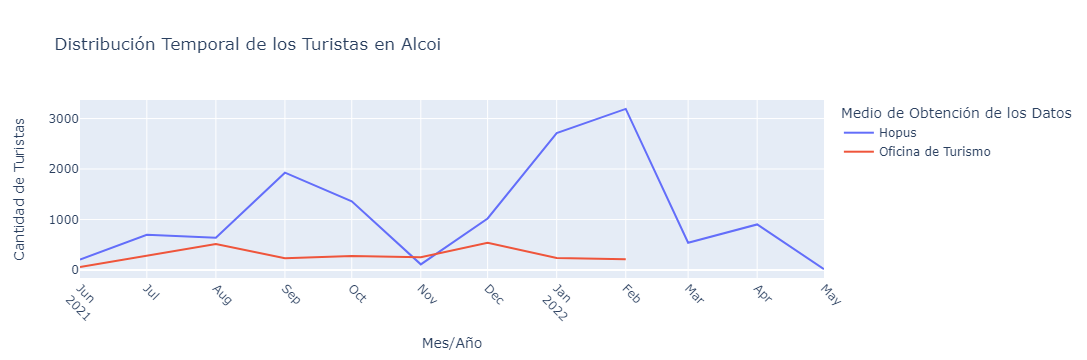

In [554]:
fig = px.line(result, x='date', y='count', color='tourist_info', 
                labels={
                 "count": "Cantidad de Turistas",
                 "date": "Mes/Año",
                 "tourist_info": "Medio de Obtención de los Datos"
                },
              title='Distribución Temporal de los Turistas en Alcoi')
fig.update_xaxes(tickangle=45, 
                dtick="M1",
                tickformat="%b\n%Y")
fig.show()

- Podemos observar que de los datos recolectados del `Hopus` estos representan una mayor proporción comparados a los recolectados por la oficina de `Tourist Info`, esto es un indicador de como menciona el artículo de referencia, las personas más y más se informan mediante internet antes de visitar lugares turísticos.

- Menos y menos turistas acuden a las oficnas de información turistica para poder informarse.

# Time Series Prediction

En el siguiente apartado intentaremos aplicar téçnicas de análisis de series temporales para aproximar la cantidad de turistas en fechas futuras.

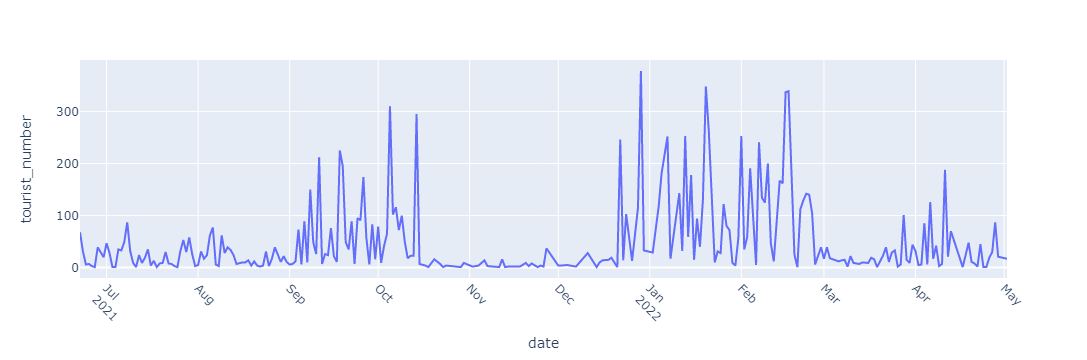

In [555]:
temporal_series_df = sensor_df.copy()

temporal_series_df = temporal_series_df[(temporal_series_df.ssid.isin(sorted_macs.ssid)) & (temporal_series_df.mac.isin(sorted_macs.mac))]

# Solo extraemos la fecha para poder hacer el análisis temporal.
temporal_series_df['date'] = pd.to_datetime(temporal_series_df['date'], unit='ms').dt.date
temporal_series_df['date'] = pd.to_datetime(temporal_series_df['date'])


time_series = temporal_series_df.groupby(by=["date"])['mac'].count()
time_series = time_series.to_frame()
time_series.reset_index(inplace=True)
time_series = time_series.rename(columns = {'mac':'tourist_number'})

fig = px.line(time_series, x="date", y="tourist_number")
fig.update_xaxes(tickangle=45, 
                dtick="M1",
                tickformat="%b\n%Y")
fig.show()

Utilizamos `statmodels` para realizar la estimación de series temporales y poder elaborar un modelo que sea capaz de aproximar la cantidad de turistas que se pueden recibir. 

> **Observación:** Este modelo puede ser demasiado impreciso debido a el proyecto de recolección del `SSIDs` empezó a funcionar en 2021, justo después de la pandemia, durante este tiempo la afluencia normal de turistas puede ser relativamente menor a la comparada con periodos anteriores a la pandemia. por este motivo se recomienda actualizar con frecuencia este modelo cada mes.  


In [556]:
time_series.set_index('date', inplace=True)
time_series.sort_index(inplace=True)

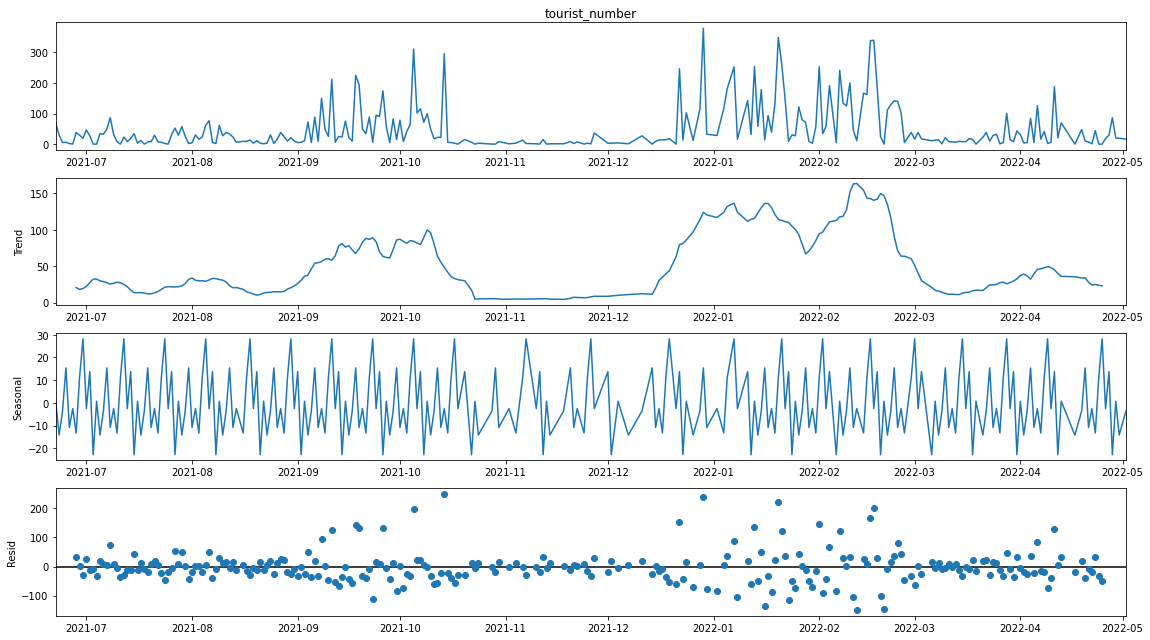

In [557]:

sd = seasonal_decompose(time_series['tourist_number'] ,model='additive', period=12)

fig = sd.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

In [558]:

time_series['tourist_number'] = time_series['tourist_number']

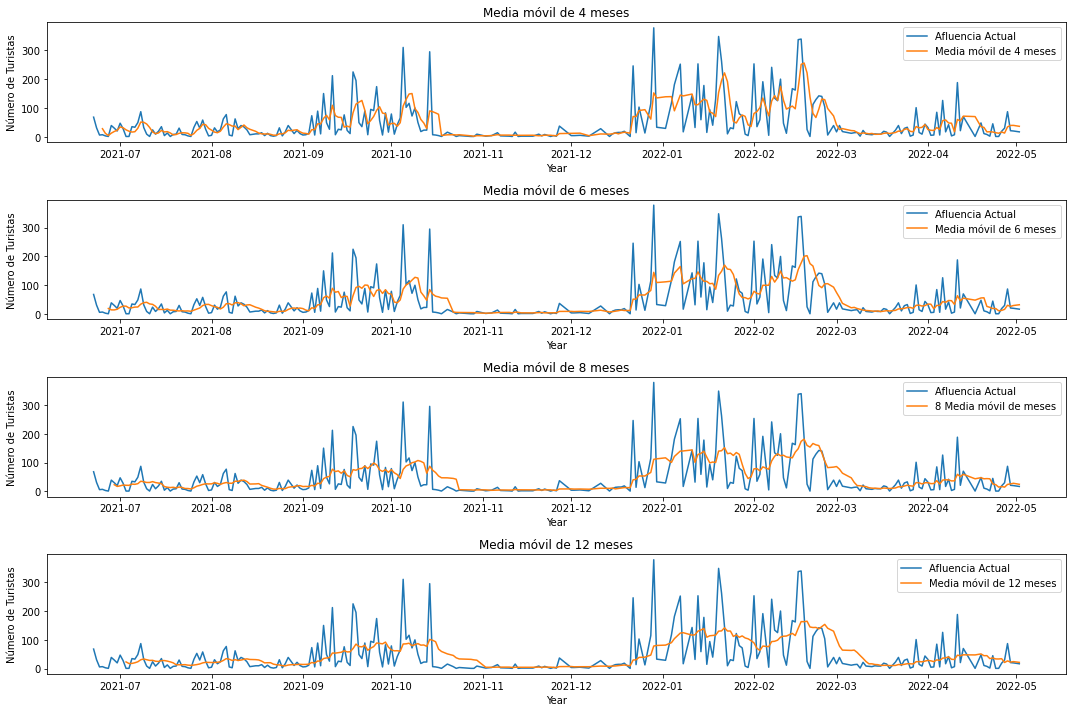

In [563]:

fig,axes = plt.subplots(4)
fig.set_figheight(10)
fig.set_figwidth(15)
axes[0].plot(time_series.index,time_series['tourist_number'],label='Afluencia Actual')
axes[0].plot(time_series.index,time_series['tourist_number'].rolling(window=4).mean(),label='Media móvil de 4 meses')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Número de Turistas')
axes[0].set_title('Media móvil de 4 meses')
axes[0].legend(loc='best')


axes[1].plot(time_series.index,time_series['tourist_number'],label='Afluencia Actual')
axes[1].plot(time_series.index,time_series['tourist_number'].rolling(window=6).mean(),label='Media móvil de 6 meses')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Número de Turistas')
axes[1].set_title('Media móvil de 6 meses')
axes[1].legend(loc='best')



axes[2].plot(time_series.index,time_series['tourist_number'],label='Afluencia Actual')
axes[2].plot(time_series.index,time_series['tourist_number'].rolling(window=8).mean(),label='8 Media móvil de meses')
axes[2].set_xlabel('Year')
axes[2].set_ylabel('Número de Turistas')
axes[2].set_title('Media móvil de 8 meses')
axes[2].legend(loc='best')


axes[3].plot(time_series.index,time_series['tourist_number'],label='Afluencia Actual')
axes[3].plot(time_series.index,time_series['tourist_number'].rolling(window=12).mean(),label='Media móvil de 12 meses')
axes[3].set_xlabel('Year')
axes[3].set_ylabel('Número de Turistas')
axes[3].set_title('Media móvil de 12 meses')
axes[3].legend(loc='best')

plt.tight_layout()
plt.show()

# Referencias

[CÓMO MEDIR LA POBLACIÓN TURÍSTICA REAL: ALCOY TOURIST LAB](https://www.turismecv.com/2021/11/30/como-medir-la-poblacion-turistica-real-alcoy-tourist-lab/)